# 02 — Exploratory Data Analysis

Comprehensive EDA with statistical rigor and business-relevant insights.

In [5]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

PROJECT_ROOT = Path.cwd()
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))
else:
    PROJECT_ROOT = PROJECT_ROOT.parent
    sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import *

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 120


REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

## 2.1 Load Data

In [6]:
conn = get_db_connection()
df = pd.read_sql_query("SELECT * FROM reviews", conn)
print(f"Loaded {len(df):,} reviews")
print(df.dtypes)
df.head()

Loaded 753,445 reviews
review_id                 int64
hotel_id                  int64
author_id                object
title                    object
text                     object
date                     object
date_parsed              object
year                      int64
month                     int64
date_stayed              object
rating_service          float64
rating_cleanliness      float64
rating_overall          float64
rating_value            float64
rating_location         float64
rating_sleep_quality    float64
rating_rooms            float64
num_helpful_votes         int64
via_mobile                int64
dtype: object


,review_id,hotel_id,author_id,title,text,date,date_parsed,year,month,date_stayed,rating_service,rating_cleanliness,rating_overall,rating_value,rating_location,rating_sleep_quality,rating_rooms,num_helpful_votes,via_mobile
0,12177337,114581,0D2A83CD60A45FEAA3A5D8EFDC33A0BA,“Loved the view”,We had a room overlooking Lake Michigan. We co...,"January 1, 2008",2008-01-01,2008,1,December 2007,5.0,5.0,4.0,4.0,5.0,NaN,4.0,4,0
1,12178200,111408,917C36A97D21E426B0B46F4CF7FFD909,“LOVED Henderson's Wharf Inn!”,We just returned from a fabulous stay at Hende...,"January 1, 2008",2008-01-01,2008,1,December 2007,5.0,5.0,5.0,5.0,5.0,NaN,5.0,2,0
2,12178519,217510,C600E1FEC17BFC4DEDB22237C0FCFD49,“No frills but good”,I was a little skeptical about staying here si...,"January 1, 2008",2008-01-01,2008,1,December 2007,3.0,4.0,3.0,3.0,4.0,NaN,3.0,2,0
3,12178586,80327,438F724059D5EE9A439C8B5A95BB6704,“Not really in San Diego”,The hotel is just south of Escondido and a goo...,"January 1, 2008",2008-01-01,2008,1,December 2007,4.0,4.0,4.0,4.0,2.0,NaN,4.0,0,0
4,12178640,93454,65391C110D7601A0A2E17811BEFC303B,“Bait and Switch?”,"The hotel itself was okay - location was good,...","January 1, 2008",2008-01-01,2008,1,December 2007,3.0,4.0,3.0,3.0,4.0,NaN,4.0,1,0


## 2.2 Rating Distributions

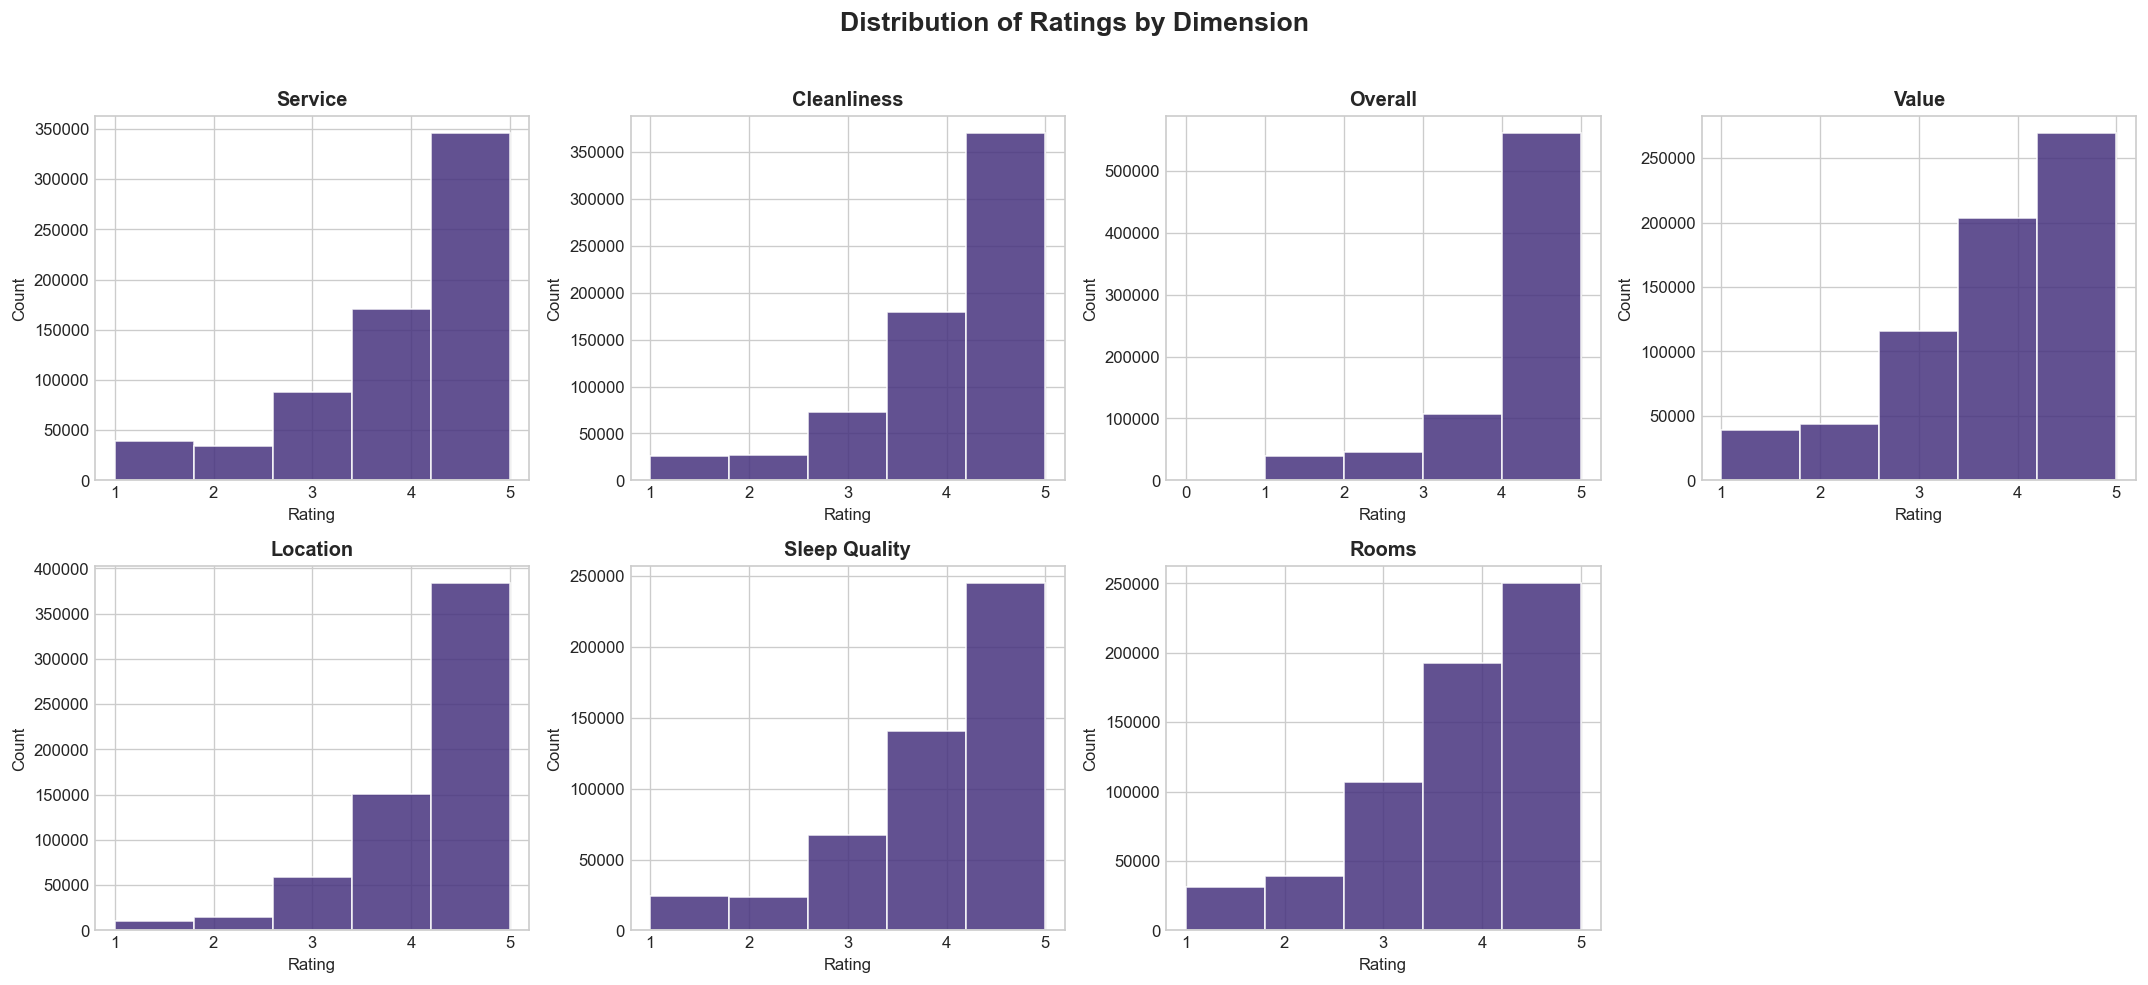

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()
for i, col in enumerate(RATING_COLUMNS):
    ax = axes[i]
    df[col].dropna().hist(bins=5, ax=ax, edgecolor="white", alpha=0.85)
    ax.set_title(RATING_LABELS[col], fontsize=12, fontweight="bold")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")
axes[-1].axis("off")
plt.suptitle("Distribution of Ratings by Dimension", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "rating_distributions.png"), bbox_inches="tight")
plt.show()

## 2.3 Correlation Between Rating Dimensions

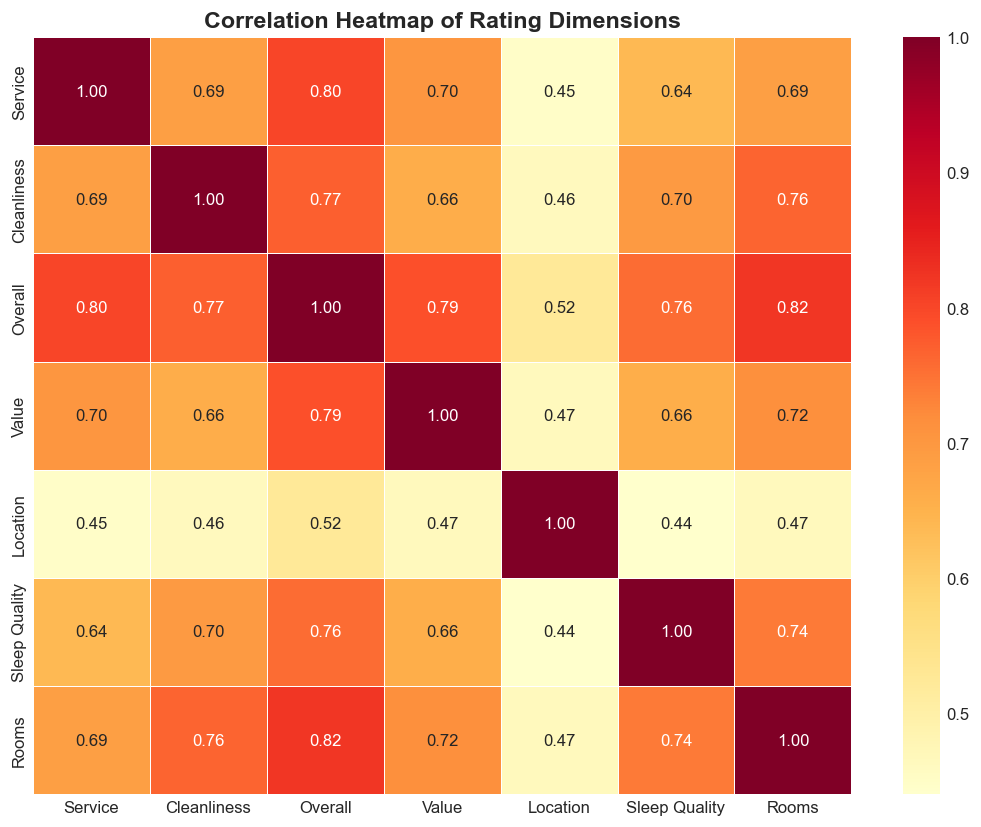

In [8]:
corr = df[RATING_COLUMNS].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=0.5,
            xticklabels=[RATING_LABELS[c] for c in RATING_COLUMNS],
            yticklabels=[RATING_LABELS[c] for c in RATING_COLUMNS])
plt.title("Correlation Heatmap of Rating Dimensions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "correlation_heatmap.png"), bbox_inches="tight")
plt.show()

## 2.4 Time-Series Trends

/var/folders/7v/4q7r0xwd6tb59mlws6_tzcm40000gn/T/ipykernel_92091/4275648972.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("date_parsed").resample("M")["rating_overall"].agg(["mean", "count"])


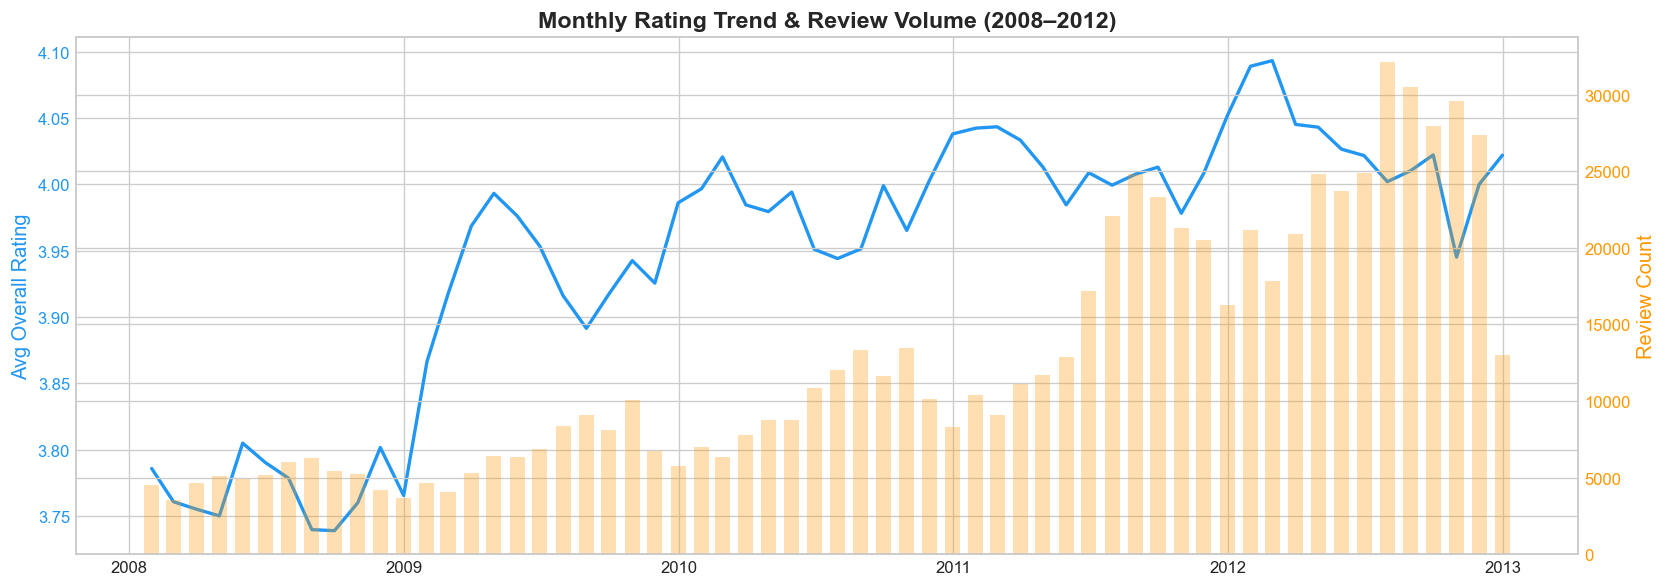

In [9]:
df["date_parsed"] = pd.to_datetime(df["date_parsed"])
monthly = df.set_index("date_parsed").resample("M")["rating_overall"].agg(["mean", "count"])

fig, ax1 = plt.subplots(figsize=(14, 5))
color1, color2 = "#2196F3", "#FF9800"
ax1.plot(monthly.index, monthly["mean"], color=color1, linewidth=2, label="Avg Overall Rating")
ax1.set_ylabel("Avg Overall Rating", color=color1, fontsize=12)
ax1.tick_params(axis="y", labelcolor=color1)

ax2 = ax1.twinx()
ax2.bar(monthly.index, monthly["count"], width=20, alpha=0.3, color=color2, label="Review Count")
ax2.set_ylabel("Review Count", color=color2, fontsize=12)
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Monthly Rating Trend & Review Volume (2008–2012)", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.savefig(str(REPORTS_DIR / "monthly_trend.png"), bbox_inches="tight")
plt.show()

## 2.5 Top & Bottom Hotels

In [10]:
hotel_stats = df.groupby("hotel_id").agg(
    avg_overall=("rating_overall", "mean"),
    num_reviews=("rating_overall", "count")
).query("num_reviews >= 30")

print("=== Top 10 Hotels (by avg overall rating, min 30 reviews) ===")
print(hotel_stats.nlargest(10, "avg_overall").round(2).to_string())
print("=== Bottom 10 Hotels ===")
print(hotel_stats.nsmallest(10, "avg_overall").round(2).to_string())

=== Top 10 Hotels (by avg overall rating, min 30 reviews) ===
          avg_overall  num_reviews
hotel_id                          
1175274          4.87          306
80092            4.87          128
1465151          4.86           83
2196840          4.85          160
1516481          4.83          687
2627745          4.82           90
781627           4.82          472
2322597          4.81          197
258705           4.80         1413
80983            4.79          576
=== Bottom 10 Hotels ===
          avg_overall  num_reviews
hotel_id                          
596421           1.42           36
100506           1.68           69
673661           1.73           99
98048            1.74           34
1635868          1.74           54
95264            1.76           46
81246            1.76          101
108255           1.78           41
217240           1.79           47
96684            1.79           52


## 2.6 Review Length vs. Rating

/var/folders/7v/4q7r0xwd6tb59mlws6_tzcm40000gn/T/ipykernel_92091/2904471337.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="rating_overall", y="text_length", palette="viridis")


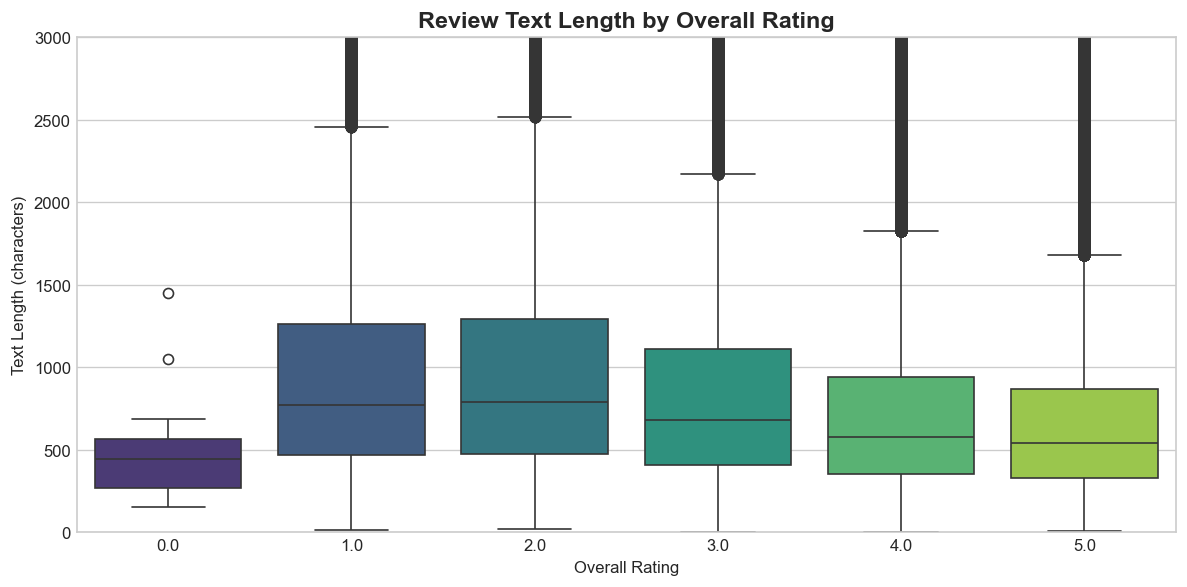

Pearson r = -0.1520, p-value = 0.00e+00


In [11]:
df["text_length"] = df["text"].str.len()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="rating_overall", y="text_length", palette="viridis")
plt.title("Review Text Length by Overall Rating", fontsize=14, fontweight="bold")
plt.xlabel("Overall Rating")
plt.ylabel("Text Length (characters)")
plt.ylim(0, 3000)
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "length_vs_rating.png"), bbox_inches="tight")
plt.show()

# Correlation
r, p = stats.pearsonr(df["text_length"].dropna(), df["rating_overall"].dropna())
print(f"Pearson r = {r:.4f}, p-value = {p:.2e}")

## 2.7 Mobile vs. Desktop Reviews

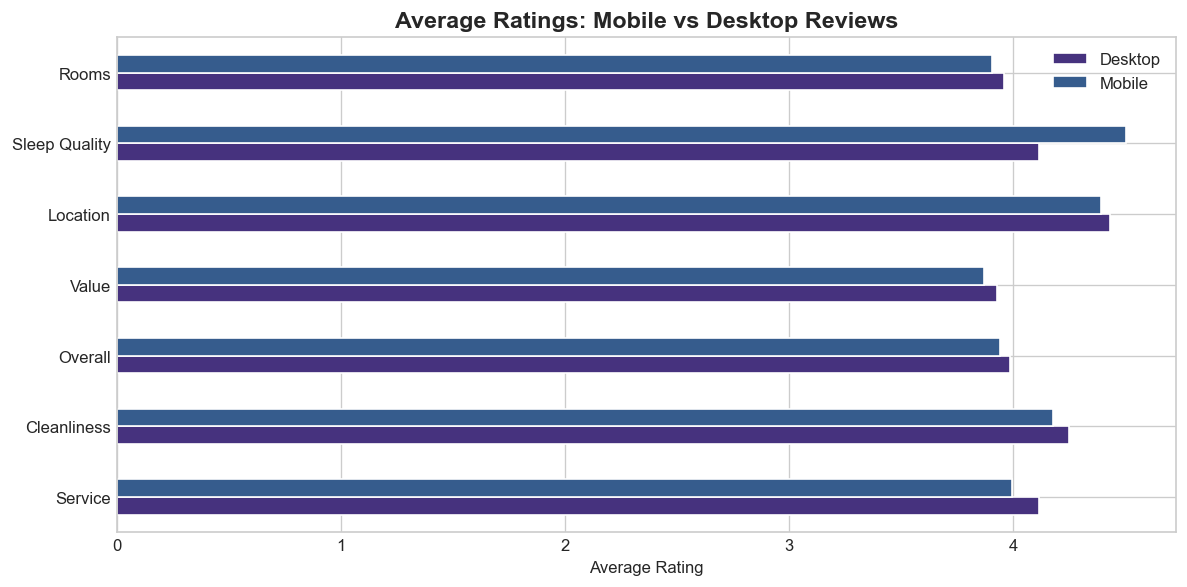

In [12]:
mobile = df.groupby("via_mobile")[RATING_COLUMNS].mean().T
mobile.columns = ["Desktop", "Mobile"]
mobile.index = [RATING_LABELS[c] for c in RATING_COLUMNS]

mobile.plot(kind="barh", figsize=(10, 5), edgecolor="white")
plt.title("Average Ratings: Mobile vs Desktop Reviews", fontsize=14, fontweight="bold")
plt.xlabel("Average Rating")
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "mobile_vs_desktop.png"), bbox_inches="tight")
plt.show()

## 2.8 Statistical Test: ANOVA on Ratings by Year

In [13]:
groups = [g["rating_overall"].dropna().values for _, g in df.groupby("year")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"One-way ANOVA: F = {f_stat:.2f}, p = {p_val:.2e}")
if p_val < 0.05:
    print("→ Significant difference in overall ratings across years.")
else:
    print("→ No significant difference across years.")

One-way ANOVA: F = 688.22, p = 0.00e+00
→ Significant difference in overall ratings across years.


## 2.9 Word Cloud of Review Text (Sample)

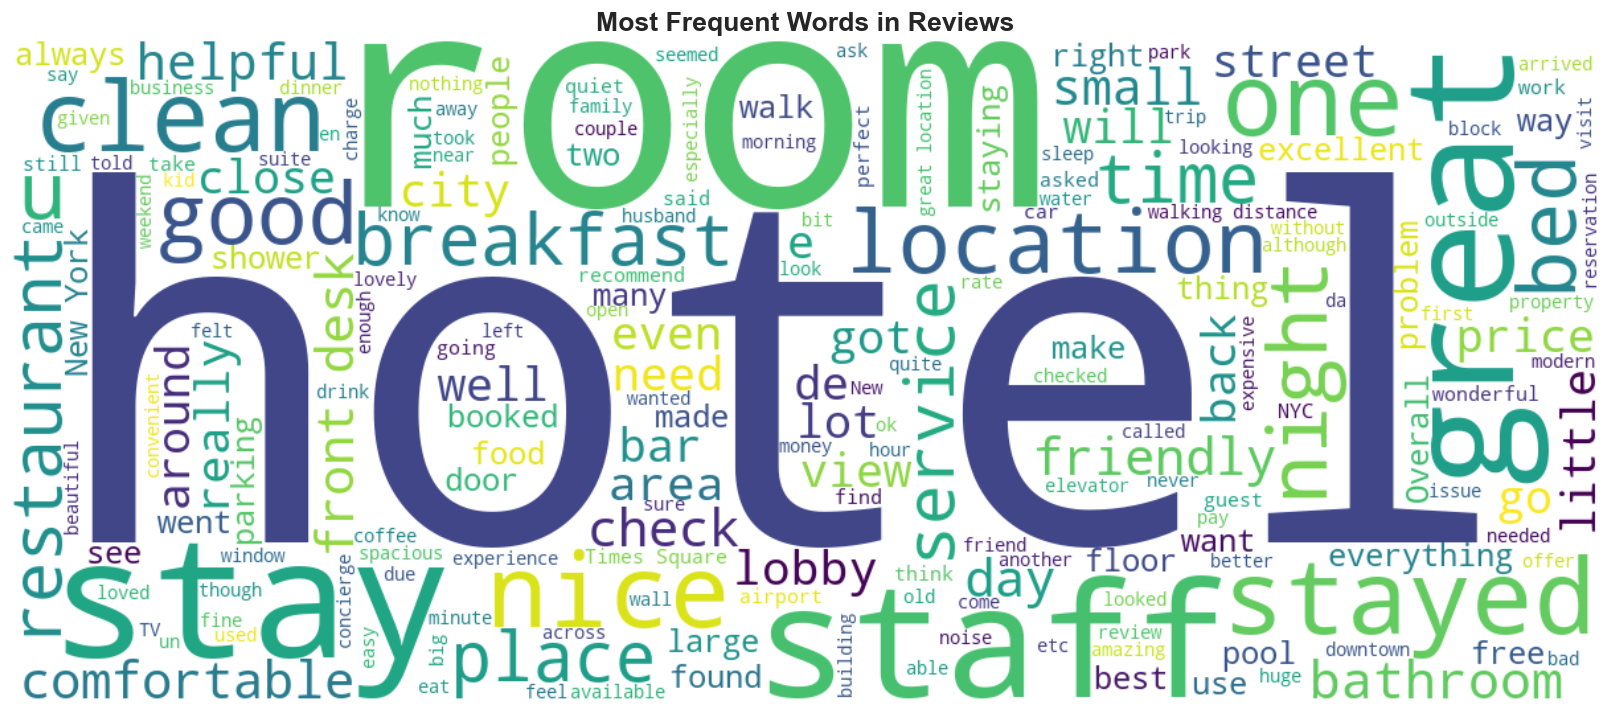

In [14]:
try:
    from wordcloud import WordCloud
    text_sample = " ".join(df["text"].dropna().sample(5000, random_state=42))
    wc = WordCloud(width=1200, height=500, background_color="white",
                   colormap="viridis", max_words=200).generate(text_sample)
    plt.figure(figsize=(14, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Frequent Words in Reviews", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(str(REPORTS_DIR / "wordcloud.png"), bbox_inches="tight")
    plt.show()
except ImportError:
    print("Install wordcloud: pip install wordcloud")

In [15]:
conn.close()
print("EDA complete ✓")

EDA complete ✓
